In [1]:
import eland as ed
from elasticsearch import Elasticsearch

client = Elasticsearch("http://localhost:9200", basic_auth = ("elastic", "changeme"), request_timeout = 120)

### Load documents

In [2]:
# Create index with mappings (.e. data types)

FLIGHTS_INDEX_NAME = "flights"
FLIGHTS_MAPPING = {
    "mappings": {
        "properties": {
            "AvgTicketPrice": {"type": "float"},
            "Cancelled": {"type": "boolean"},
            "Carrier": {"type": "keyword"},
            "Dest": {"type": "keyword"},
            "DestAirportID": {"type": "keyword"},
            "DestCityName": {"type": "keyword"},
            "DestCountry": {"type": "keyword"},
            "DestLocation": {"type": "geo_point"},
            "DestRegion": {"type": "keyword"},
            "DestWeather": {"type": "keyword"},
            "DistanceKilometers": {"type": "float"},
            "DistanceMiles": {"type": "float"},
            "FlightDelay": {"type": "boolean"},
            "FlightDelayMin": {"type": "integer"},
            "FlightDelayType": {"type": "keyword"},
            "FlightNum": {"type": "keyword"},
            "FlightTimeHour": {"type": "float"},
            "FlightTimeMin": {"type": "float"},
            "Origin": {"type": "keyword"},
            "OriginAirportID": {"type": "keyword"},
            "OriginCityName": {"type": "keyword"},
            "OriginCountry": {"type": "keyword"},
            "OriginLocation": {"type": "geo_point"},
            "OriginRegion": {"type": "keyword"},
            "OriginWeather": {"type": "keyword"},
            "dayOfWeek": {"type": "byte"},
            "timestamp": {"type": "date", "format": "strict_date_hour_minute_second"},
        }
    }
}

# Check if the index already exists
if not client.indices.exists(index = FLIGHTS_INDEX_NAME):
    # Create the index with the specified mappings
    client.indices.create(index = FLIGHTS_INDEX_NAME, body = FLIGHTS_MAPPING)
    print(f"Index '{FLIGHTS_INDEX_NAME}' created.")
else:
    print(f"Index '{FLIGHTS_INDEX_NAME}' already exists.")

Index 'flights' already exists.


In [3]:
import os
import json
import gzip

import tempfile
import requests
import pandas as pd

with tempfile.TemporaryDirectory() as tmpdir:
    r = requests.get("https://github.com/elastic/eland/raw/main/tests/flights.json.gz")
    path = os.path.join(tmpdir, "flights.json.gz")
    with open(path, "wb") as f:
        f.write(r.content)

        with gzip.open(path, 'rt', encoding='utf-8') as gfile:
            # Read the JSON objects into a list
            # Each line in the file is a separate JSON object
            data = [json.loads(line) for line in gfile]

df = pd.DataFrame(data)
df.head()

,FlightNum,DestCountry,OriginWeather,OriginCityName,AvgTicketPrice,DistanceMiles,FlightDelay,DestWeather,Dest,FlightDelayType,...,Cancelled,FlightTimeMin,Origin,OriginLocation,DestRegion,OriginAirportID,OriginRegion,DestCityName,FlightTimeHour,FlightDelayMin
0,9HY9SWR,AU,Sunny,Frankfurt am Main,841.265642,10247.856676,False,Rain,Sydney Kingsford Smith International Airport,No Delay,...,False,1030.770416,Frankfurt am Main Airport,"{'lat': '50.033333', 'lon': '8.570556'}",SE-BD,FRA,DE-HE,Sydney,17.179507,0
1,X98CCZO,IT,Clear,Cape Town,882.982662,5482.606665,False,Sunny,Venice Marco Polo Airport,No Delay,...,False,464.389481,Cape Town International Airport,"{'lat': '-33.96480179', 'lon': '18.60169983'}",IT-34,CPT,SE-BD,Venice,7.739825,0
2,UFK2WIZ,IT,Rain,Venice,190.636904,0.000000,False,Cloudy,Venice Marco Polo Airport,No Delay,...,False,0.000000,Venice Marco Polo Airport,"{'lat': '45.505299', 'lon': '12.3519'}",IT-34,VE05,IT-34,Venice,0.000000,0
3,EAYQW69,IT,Thunder & Lightning,Naples,181.694216,345.319439,True,Clear,Treviso-Sant'Angelo Airport,Weather Delay,...,True,222.749059,Naples International Airport,"{'lat': '40.886002', 'lon': '14.2908'}",IT-34,NA01,IT-72,Treviso,3.712484,180
4,58U013N,CN,Damaging Wind,Mexico City,730.041778,8300.428125,False,Clear,Xi'an Xianyang International Airport,No Delay,...,False,785.779071,Licenciado Benito Juarez International Airport,"{'lat': '19.4363', 'lon': '-99.072098'}",SE-BD,AICM,MX-DIF,Xi'an,13.096318,0


In [4]:
from elasticsearch.helpers import bulk

def generate_actions(data):
    for idx, entry in enumerate(data):
        yield {
            "_index": FLIGHTS_INDEX_NAME,
            "_id": idx,
            "_source": entry
        }

try:
    # Set raise_on_error to False so the bulk operation continues after errors
    success, errors = bulk(client, generate_actions(data), raise_on_error=False, stats_only=True)
    print(f"Indexing completed. Successfully indexed {success} documents.")

    if errors:
        print(f"Some errors occurred. {errors} documents were not indexed.")
    else:
        print("All documents were indexed successfully without errors.")
except Exception as e:
    print(f"An unexpected error occurred while indexing: {e}. Please check the Elasticsearch logs for more details.")


Indexing completed. Successfully indexed 13014 documents.
Some errors occurred. 45 documents were not indexed.


### Read index into dataframe with eland

In [5]:
ed_df = ed.DataFrame(client, es_index_pattern = "flights")

In [6]:
type(ed_df)

eland.dataframe.DataFrame

In [7]:
ed_df.columns

Index(['AvgTicketPrice', 'Cancelled', 'Carrier', 'Dest', 'DestAirportID',
       'DestCityName', 'DestCountry', 'DestLocation', 'DestRegion',
       'DestWeather', 'DistanceKilometers', 'DistanceMiles', 'FlightDelay',
       'FlightDelayMin', 'FlightDelayType', 'FlightNum', 'FlightTimeHour',
       'FlightTimeMin', 'Origin', 'OriginAirportID', 'OriginCityName',
       'OriginCountry', 'OriginLocation', 'OriginRegion', 'OriginWeather',
       'dayOfWeek', 'timestamp'],
      dtype='object')

In [8]:
ed_df.dtypes

AvgTicketPrice               float64
Cancelled                       bool
Carrier                       object
Dest                          object
DestAirportID                 object
DestCityName                  object
DestCountry                   object
DestLocation                  object
DestRegion                    object
DestWeather                   object
DistanceKilometers           float64
DistanceMiles                float64
FlightDelay                     bool
FlightDelayMin                 int64
FlightDelayType               object
FlightNum                     object
FlightTimeHour               float64
FlightTimeMin                float64
Origin                        object
OriginAirportID               object
OriginCityName                object
OriginCountry                 object
OriginLocation                object
OriginRegion                  object
OriginWeather                 object
dayOfWeek                      int64
timestamp             datetime64[ns]
d

In [9]:
import numpy as np

ed_df.select_dtypes(include = np.number)

,AvgTicketPrice,DistanceKilometers,DistanceMiles,FlightDelayMin,FlightTimeHour,FlightTimeMin,dayOfWeek
4500,251.866779,844.926404,525.012927,195,4.032339,241.940356,0
4501,728.754376,3914.257672,2432.206956,0,3.261881,195.712884,0
4502,719.150212,8320.909234,5170.373291,0,6.934091,416.045462,0
4503,259.731232,2728.352801,1695.319833,0,3.031503,181.890187,0
4504,598.938800,10641.536703,6612.344348,0,14.779912,886.794725,0
...,...,...,...,...,...,...,...
13054,1080.446279,8058.581753,5007.370551,0,6.715485,402.929088,6
13055,646.612941,7088.598322,4404.650791,0,10.740300,644.418029,6
13056,997.751876,10920.652972,6785.779157,255,15.625680,937.540811,6
13057,1102.814465,18748.859647,11650.001272,135,28.290083,1697.404971,6


In [10]:
ed_df.empty

False

In [11]:
ed_df.shape

(13014, 27)

In [12]:
ed_df.index

In [13]:
ed_df.index.es_index_field

'_id'

In [14]:
ed_df.head()

,AvgTicketPrice,Cancelled,Carrier,Dest,DestAirportID,DestCityName,DestCountry,DestLocation,DestRegion,DestWeather,...,FlightTimeMin,Origin,OriginAirportID,OriginCityName,OriginCountry,OriginLocation,OriginRegion,OriginWeather,dayOfWeek,timestamp
4500,251.866779,False,Logstash Airways,Pisa International Airport,PI05,Pisa,IT,"{'lat': '43.683899', 'lon': '10.3927'}",IT-52,Sunny,...,241.940356,Charles de Gaulle International Airport,CDG,Paris,FR,"{'lat': '49.01279831', 'lon': '2.549999952'}",FR-J,Clear,0,2018-01-15 07:21:49
4501,728.754376,False,Logstash Airways,Xi'an Xianyang International Airport,XIY,Xi'an,CN,"{'lat': '34.447102', 'lon': '108.751999'}",SE-BD,Clear,...,195.712884,Kempegowda International Airport,BLR,Bangalore,IN,"{'lat': '13.1979', 'lon': '77.706299'}",SE-BD,Clear,0,2018-01-15 01:30:54
4502,719.150212,False,ES-Air,Oslo Gardermoen Airport,OSL,Oslo,NO,"{'lat': '60.19390106', 'lon': '11.10039997'}",NO-02,Clear,...,416.045462,Itami Airport,ITM,Osaka,JP,"{'lat': '34.78549957', 'lon': '135.4380035'}",SE-BD,Heavy Fog,0,2018-01-15 05:20:30
4503,259.731232,True,ES-Air,Licenciado Benito Juarez International Airport,AICM,Mexico City,MX,"{'lat': '19.4363', 'lon': '-99.072098'}",MX-DIF,Heavy Fog,...,181.890187,Fort Wayne International Airport,FWA,Fort Wayne,US,"{'lat': '40.97850037', 'lon': '-85.19509888'}",US-IN,Sunny,0,2018-01-15 05:20:30
4504,598.938800,False,Kibana Airlines,Lester B. Pearson International Airport,YYZ,Toronto,CA,"{'lat': '43.67720032', 'lon': '-79.63059998'}",CA-ON,Clear,...,886.794725,Incheon International Airport,ICN,Seoul,KR,"{'lat': '37.46910095', 'lon': '126.4509964'}",SE-BD,Cloudy,0,2018-01-15 03:37:57


In [15]:
ed_df.tail()

,AvgTicketPrice,Cancelled,Carrier,Dest,DestAirportID,DestCityName,DestCountry,DestLocation,DestRegion,DestWeather,...,FlightTimeMin,Origin,OriginAirportID,OriginCityName,OriginCountry,OriginLocation,OriginRegion,OriginWeather,dayOfWeek,timestamp
13054,1080.446279,False,Logstash Airways,Xi'an Xianyang International Airport,XIY,Xi'an,CN,"{'lat': '34.447102', 'lon': '108.751999'}",SE-BD,Rain,...,402.929088,Pisa International Airport,PI05,Pisa,IT,"{'lat': '43.683899', 'lon': '10.3927'}",IT-52,Sunny,6,2018-02-11 20:42:25
13055,646.612941,False,Logstash Airways,Zurich Airport,ZRH,Zurich,CH,"{'lat': '47.464699', 'lon': '8.54917'}",CH-ZH,Rain,...,644.418029,Winnipeg / James Armstrong Richardson Internat...,YWG,Winnipeg,CA,"{'lat': '49.90999985', 'lon': '-97.23989868'}",CA-MB,Rain,6,2018-02-11 01:41:57
13056,997.751876,False,Logstash Airways,Ukrainka Air Base,XHBU,Belogorsk,RU,"{'lat': '51.169997', 'lon': '128.445007'}",RU-AMU,Rain,...,937.540811,Licenciado Benito Juarez International Airport,AICM,Mexico City,MX,"{'lat': '19.4363', 'lon': '-99.072098'}",MX-DIF,Sunny,6,2018-02-11 04:09:27
13057,1102.814465,False,JetBeats,Ministro Pistarini International Airport,EZE,Buenos Aires,AR,"{'lat': '-34.8222', 'lon': '-58.5358'}",SE-BD,Hail,...,1697.404971,Itami Airport,ITM,Osaka,JP,"{'lat': '34.78549957', 'lon': '135.4380035'}",SE-BD,Hail,6,2018-02-11 08:28:21
13058,858.144337,False,JetBeats,Washington Dulles International Airport,IAD,Washington,US,"{'lat': '38.94449997', 'lon': '-77.45580292'}",US-DC,Heavy Fog,...,1610.761827,Adelaide International Airport,ADL,Adelaide,AU,"{'lat': '-34.945', 'lon': '138.531006'}",SE-BD,Rain,6,2018-02-11 14:54:34


In [16]:
ed_df.keys()

Index(['AvgTicketPrice', 'Cancelled', 'Carrier', 'Dest', 'DestAirportID',
       'DestCityName', 'DestCountry', 'DestLocation', 'DestRegion',
       'DestWeather', 'DistanceKilometers', 'DistanceMiles', 'FlightDelay',
       'FlightDelayMin', 'FlightDelayType', 'FlightNum', 'FlightTimeHour',
       'FlightTimeMin', 'Origin', 'OriginAirportID', 'OriginCityName',
       'OriginCountry', 'OriginLocation', 'OriginRegion', 'OriginWeather',
       'dayOfWeek', 'timestamp'],
      dtype='object')

In [17]:
ed_df.get("Carrier")

4500     Logstash Airways
4501     Logstash Airways
4502               ES-Air
4503               ES-Air
4504      Kibana Airlines
               ...       
13054    Logstash Airways
13055    Logstash Airways
13056    Logstash Airways
13057            JetBeats
13058            JetBeats
Name: Carrier, Length: 13014, dtype: object

In [18]:
ed_df[(ed_df.Carrier=="Kibana Airlines") & (ed_df.AvgTicketPrice > 900.0) & (ed_df.Cancelled == True)]

,AvgTicketPrice,Cancelled,Carrier,Dest,DestAirportID,DestCityName,DestCountry,DestLocation,DestRegion,DestWeather,...,FlightTimeMin,Origin,OriginAirportID,OriginCityName,OriginCountry,OriginLocation,OriginRegion,OriginWeather,dayOfWeek,timestamp
4662,902.297050,True,Kibana Airlines,Montreal / Pierre Elliott Trudeau Internationa...,YUL,Montreal,CA,"{'lat': '45.47060013', 'lon': '-73.74079895'}",CA-QC,Damaging Wind,...,762.574960,Abu Dhabi International Airport,AUH,Abu Dhabi,AE,"{'lat': '24.43300056', 'lon': '54.65110016'}",SE-BD,Sunny,0,2018-01-15 14:28:38
4815,995.477120,True,Kibana Airlines,Xi'an Xianyang International Airport,XIY,Xi'an,CN,"{'lat': '34.447102', 'lon': '108.751999'}",SE-BD,Sunny,...,235.287722,Tokyo Haneda International Airport,HND,Tokyo,JP,"{'lat': '35.552299', 'lon': '139.779999'}",SE-BD,Thunder & Lightning,1,2018-01-16 07:27:07
5175,956.451207,True,Kibana Airlines,Munich Airport,MUC,Munich,DE,"{'lat': '48.353802', 'lon': '11.7861'}",DE-BY,Sunny,...,427.494775,Al Maktoum International Airport,DWC,Jebel Ali,AE,"{'lat': '24.896356', 'lon': '55.161389'}",SE-BD,Hail,2,2018-01-17 06:18:00
5317,996.495850,True,Kibana Airlines,Ministro Pistarini International Airport,EZE,Buenos Aires,AR,"{'lat': '-34.8222', 'lon': '-58.5358'}",AR-B,Damaging Wind,...,1226.782087,Itami Airport,ITM,Osaka,JP,"{'lat': '34.78549957', 'lon': '135.4380035'}",SE-BD,Rain,2,2018-01-17 14:05:15
5584,957.213890,True,Kibana Airlines,Leonardo da Vinci - Fiumicino Airport,FCO,Rome,IT,"{'lat': '41.8002778', 'lon': '12.2388889'}",SE-BD,Thunder & Lightning,...,387.557078,Chhatrapati Shivaji International Airport,BOM,Mumbai,IN,"{'lat': '19.08869934', 'lon': '72.86789703'}",SE-BD,Sunny,3,2018-01-18 16:16:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12820,909.973606,True,Kibana Airlines,Ottawa Macdonald-Cartier International Airport,YOW,Ottawa,CA,"{'lat': '45.32249832', 'lon': '-75.66919708'}",CA-ON,Damaging Wind,...,556.371247,Incheon International Airport,ICN,Seoul,KR,"{'lat': '37.46910095', 'lon': '126.4509964'}",SE-BD,Cloudy,5,2018-02-10 05:11:35
12906,983.429244,True,Kibana Airlines,Venice Marco Polo Airport,VE05,Venice,IT,"{'lat': '45.505299', 'lon': '12.3519'}",IT-34,Thunder & Lightning,...,685.518902,Chhatrapati Shivaji International Airport,BOM,Mumbai,IN,"{'lat': '19.08869934', 'lon': '72.86789703'}",SE-BD,Thunder & Lightning,6,2018-02-11 06:19:58
12918,1136.678150,True,Kibana Airlines,Winnipeg / James Armstrong Richardson Internat...,YWG,Winnipeg,CA,"{'lat': '49.90999985', 'lon': '-97.23989868'}",CA-MB,Heavy Fog,...,464.199349,San Antonio International Airport,SAT,San Antonio,US,"{'lat': '29.53370094', 'lon': '-98.46980286'}",US-TX,Cloudy,6,2018-02-11 16:03:10
12919,1105.211803,True,Kibana Airlines,Ukrainka Air Base,XHBU,Belogorsk,RU,"{'lat': '51.169997', 'lon': '128.445007'}",RU-AMU,Heavy Fog,...,824.024175,Ottawa Macdonald-Cartier International Airport,YOW,Ottawa,CA,"{'lat': '45.32249832', 'lon': '-75.66919708'}",CA-ON,Clear,6,2018-02-11 05:36:05


In [19]:
ed_df[['DistanceKilometers', 'AvgTicketPrice']].aggregate(['sum', 'min', 'std'])

,DistanceKilometers,AvgTicketPrice
sum,9.229730e+07,8.177881e+06
min,0.000000e+00,1.000205e+02
std,4.578132e+03,2.664956e+02


In [20]:
ed_df.count()

AvgTicketPrice        13014
Cancelled             13014
Carrier               13014
Dest                  13014
DestAirportID         13014
DestCityName          13014
DestCountry           13014
DestLocation          13014
DestRegion            13014
DestWeather           13014
DistanceKilometers    13014
DistanceMiles         13014
FlightDelay           13014
FlightDelayMin        13014
FlightDelayType       13014
FlightNum             13014
FlightTimeHour        13014
FlightTimeMin         13014
Origin                13014
OriginAirportID       13014
OriginCityName        13014
OriginCountry         13014
OriginLocation        13014
OriginRegion          13014
OriginWeather         13014
dayOfWeek             13014
timestamp             13014
dtype: int64

In [21]:
ed_df.describe()

,AvgTicketPrice,Cancelled,DistanceKilometers,DistanceMiles,FlightDelay,FlightDelayMin,FlightTimeHour,FlightTimeMin,dayOfWeek
count,13014.000000,13014.000000,13014.000000,13014.000000,13014.000000,13014.000000,13014.000000,13014.000000,13014.000000
mean,628.391013,0.128323,7092.154679,4406.860604,0.251268,47.349009,8.518439,511.106340,2.834870
std,266.495605,0.334475,4578.131555,2844.719059,0.433776,96.769936,5.577916,334.674968,1.939568
min,100.020531,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,410.504234,0.000000,2839.612010,1764.453107,0.000000,0.000000,4.160841,249.650488,1.054471
50%,639.856540,0.000000,7593.697802,4718.505049,0.000000,0.000000,8.385440,503.126391,2.745814
75%,842.236323,0.000000,9794.122981,6085.785879,0.571006,28.392544,12.021429,721.285744,4.500331
max,1199.729004,1.000000,19881.482422,12353.780273,1.000000,360.000000,31.715034,1902.901978,6.000000


In [22]:
ed_df.info()

<class 'eland.dataframe.DataFrame'>
Index: 13014 entries, 4500 to 13058
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AvgTicketPrice      13014 non-null  float64       
 1   Cancelled           13014 non-null  bool          
 2   Carrier             13014 non-null  object        
 3   Dest                13014 non-null  object        
 4   DestAirportID       13014 non-null  object        
 5   DestCityName        13014 non-null  object        
 6   DestCountry         13014 non-null  object        
 7   DestLocation        13014 non-null  object        
 8   DestRegion          13014 non-null  object        
 9   DestWeather         13014 non-null  object        
 10  DistanceKilometers  13014 non-null  float64       
 11  DistanceMiles       13014 non-null  float64       
 12  FlightDelay         13014 non-null  bool          
 13  FlightDelayMin      13014 non-null  int64         

In [23]:
ed_df.max(numeric_only = True)

AvgTicketPrice         1199.729004
Cancelled                 1.000000
DistanceKilometers    19881.482422
DistanceMiles         12353.780273
FlightDelay               1.000000
FlightDelayMin          360.000000
FlightTimeHour           31.715034
FlightTimeMin          1902.901978
dayOfWeek                 6.000000
dtype: float64

In [24]:
ed_df.min(numeric_only = True)

AvgTicketPrice        100.020531
Cancelled               0.000000
DistanceKilometers      0.000000
DistanceMiles           0.000000
FlightDelay             0.000000
FlightDelayMin          0.000000
FlightTimeHour          0.000000
FlightTimeMin           0.000000
dayOfWeek               0.000000
dtype: float64

In [25]:
ed_df.sum(numeric_only = True)

AvgTicketPrice        8.177881e+06
Cancelled             1.670000e+03
DistanceKilometers    9.229730e+07
DistanceMiles         5.735088e+07
FlightDelay           3.270000e+03
FlightDelayMin        6.162000e+05
FlightTimeHour        1.108590e+05
FlightTimeMin         6.651538e+06
dayOfWeek             3.689300e+04
dtype: float64

In [26]:
ed_df.mean(numeric_only = True)

AvgTicketPrice         628.391013
Cancelled                0.128323
DistanceKilometers    7092.154679
DistanceMiles         4406.860604
FlightDelay              0.251268
FlightDelayMin          47.349009
FlightTimeHour           8.518439
FlightTimeMin          511.106340
dayOfWeek                2.834870
dtype: float64

In [27]:
ed_df.get("Carrier").nunique()

4

In [28]:
ed_df.drop(columns = ["dayOfWeek"])

,AvgTicketPrice,Cancelled,Carrier,Dest,DestAirportID,DestCityName,DestCountry,DestLocation,DestRegion,DestWeather,...,FlightTimeHour,FlightTimeMin,Origin,OriginAirportID,OriginCityName,OriginCountry,OriginLocation,OriginRegion,OriginWeather,timestamp
4500,251.866779,False,Logstash Airways,Pisa International Airport,PI05,Pisa,IT,"{'lat': '43.683899', 'lon': '10.3927'}",IT-52,Sunny,...,4.032339,241.940356,Charles de Gaulle International Airport,CDG,Paris,FR,"{'lat': '49.01279831', 'lon': '2.549999952'}",FR-J,Clear,2018-01-15 07:21:49
4501,728.754376,False,Logstash Airways,Xi'an Xianyang International Airport,XIY,Xi'an,CN,"{'lat': '34.447102', 'lon': '108.751999'}",SE-BD,Clear,...,3.261881,195.712884,Kempegowda International Airport,BLR,Bangalore,IN,"{'lat': '13.1979', 'lon': '77.706299'}",SE-BD,Clear,2018-01-15 01:30:54
4502,719.150212,False,ES-Air,Oslo Gardermoen Airport,OSL,Oslo,NO,"{'lat': '60.19390106', 'lon': '11.10039997'}",NO-02,Clear,...,6.934091,416.045462,Itami Airport,ITM,Osaka,JP,"{'lat': '34.78549957', 'lon': '135.4380035'}",SE-BD,Heavy Fog,2018-01-15 05:20:30
4503,259.731232,True,ES-Air,Licenciado Benito Juarez International Airport,AICM,Mexico City,MX,"{'lat': '19.4363', 'lon': '-99.072098'}",MX-DIF,Heavy Fog,...,3.031503,181.890187,Fort Wayne International Airport,FWA,Fort Wayne,US,"{'lat': '40.97850037', 'lon': '-85.19509888'}",US-IN,Sunny,2018-01-15 05:20:30
4504,598.938800,False,Kibana Airlines,Lester B. Pearson International Airport,YYZ,Toronto,CA,"{'lat': '43.67720032', 'lon': '-79.63059998'}",CA-ON,Clear,...,14.779912,886.794725,Incheon International Airport,ICN,Seoul,KR,"{'lat': '37.46910095', 'lon': '126.4509964'}",SE-BD,Cloudy,2018-01-15 03:37:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13054,1080.446279,False,Logstash Airways,Xi'an Xianyang International Airport,XIY,Xi'an,CN,"{'lat': '34.447102', 'lon': '108.751999'}",SE-BD,Rain,...,6.715485,402.929088,Pisa International Airport,PI05,Pisa,IT,"{'lat': '43.683899', 'lon': '10.3927'}",IT-52,Sunny,2018-02-11 20:42:25
13055,646.612941,False,Logstash Airways,Zurich Airport,ZRH,Zurich,CH,"{'lat': '47.464699', 'lon': '8.54917'}",CH-ZH,Rain,...,10.740300,644.418029,Winnipeg / James Armstrong Richardson Internat...,YWG,Winnipeg,CA,"{'lat': '49.90999985', 'lon': '-97.23989868'}",CA-MB,Rain,2018-02-11 01:41:57
13056,997.751876,False,Logstash Airways,Ukrainka Air Base,XHBU,Belogorsk,RU,"{'lat': '51.169997', 'lon': '128.445007'}",RU-AMU,Rain,...,15.625680,937.540811,Licenciado Benito Juarez International Airport,AICM,Mexico City,MX,"{'lat': '19.4363', 'lon': '-99.072098'}",MX-DIF,Sunny,2018-02-11 04:09:27
13057,1102.814465,False,JetBeats,Ministro Pistarini International Airport,EZE,Buenos Aires,AR,"{'lat': '-34.8222', 'lon': '-58.5358'}",SE-BD,Hail,...,28.290083,1697.404971,Itami Airport,ITM,Osaka,JP,"{'lat': '34.78549957', 'lon': '135.4380035'}",SE-BD,Hail,2018-02-11 08:28:21


array([[<Axes: title={'center': 'AvgTicketPrice'}>,
        <Axes: title={'center': 'DistanceKilometers'}>,
        <Axes: title={'center': 'DistanceMiles'}>],
       [<Axes: title={'center': 'FlightDelayMin'}>,
        <Axes: title={'center': 'FlightTimeHour'}>,
        <Axes: title={'center': 'FlightTimeMin'}>],
       [<Axes: title={'center': 'dayOfWeek'}>, <Axes: >, <Axes: >]],
      dtype=object)

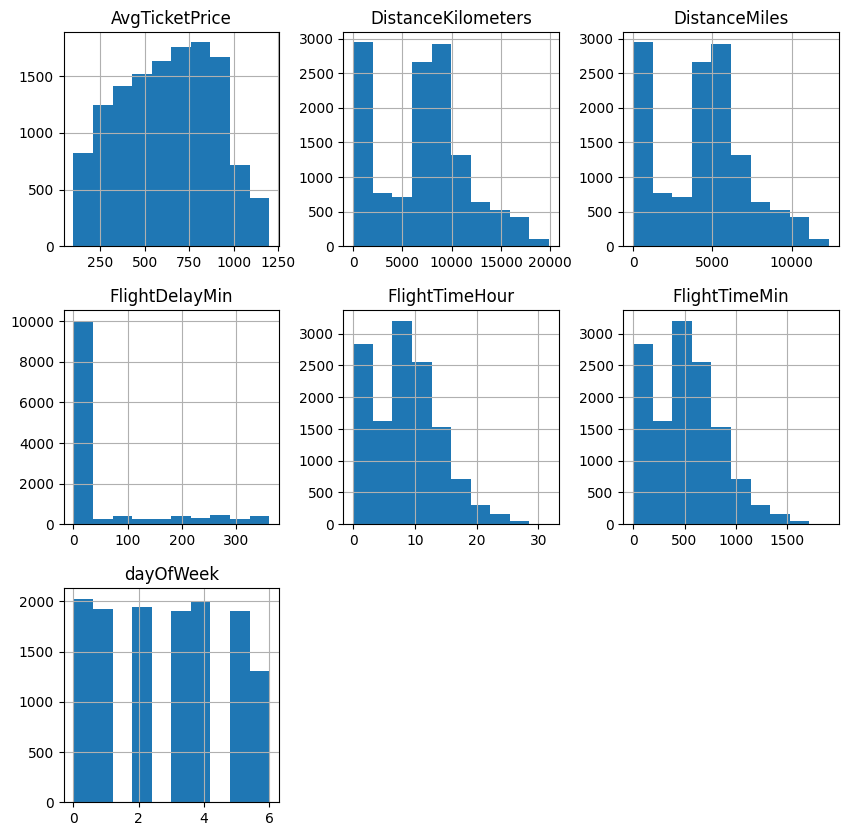

In [29]:
ed_df.select_dtypes(include=np.number).hist(figsize=[10,10])

In [30]:
# Convert to pandas dataframe
pd_df = ed.eland_to_pandas(ed_df)
type(pd_df)

pandas.core.frame.DataFrame

In [31]:
pd_df.columns

Index(['AvgTicketPrice', 'Cancelled', 'Carrier', 'Dest', 'DestAirportID',
       'DestCityName', 'DestCountry', 'DestLocation', 'DestRegion',
       'DestWeather', 'DistanceKilometers', 'DistanceMiles', 'FlightDelay',
       'FlightDelayMin', 'FlightDelayType', 'FlightNum', 'FlightTimeHour',
       'FlightTimeMin', 'Origin', 'OriginAirportID', 'OriginCityName',
       'OriginCountry', 'OriginLocation', 'OriginRegion', 'OriginWeather',
       'dayOfWeek', 'timestamp'],
      dtype='object')

### Train a model

In [43]:
from xgboost import XGBClassifier
from eland.ml import MLModel

# Load data
# feature_columns = ['AvgTicketPrice', 'Carrier', 'Dest', 'DestAirportID',
#        'DestCityName', 'DestCountry', 'DestRegion',
#        'DestWeather', 'DistanceKilometers', 'DistanceMiles', 'FlightTimeHour',
#        'FlightTimeMin', 'Origin', 'OriginAirportID', 'OriginCityName',
#        'OriginCountry', 'OriginRegion', 'OriginWeather', 'dayOfWeek']
feature_columns = ['AvgTicketPrice', 'DistanceKilometers', 'DistanceMiles', 'FlightTimeHour',
       'FlightTimeMin', 'dayOfWeek']
label_column = "FlightDelay"

# for column in feature_columns:
#     if isinstance(pd_df[column].values[0], str):
#         pd_df[column] = pd_df[column].astype("category")

df_train = pd_df.sample(frac = 0.8)
df_test = pd_df[~pd_df.index.isin(df_train.index)]

In [46]:
# Train model locally
model = XGBClassifier(booster = "gbtree", enable_categorical = True)
model.fit(df_train[feature_columns], df_train[label_column])

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [47]:
preds = model.predict(df_test[feature_columns])
preds

array([0, 1, 0, ..., 0, 0, 0])

In [48]:
# Import model into elastic
es_model = MLModel.import_model(
    es_client = client,
    model_id = "custom-xgb-classifier",
    model = model,
    feature_names = ['AvgTicketPrice', 'DistanceKilometers', 'DistanceMiles', 'FlightTimeHour',
       'FlightTimeMin', 'dayOfWeek'],
)

In [49]:
# Make a get request to endpoint to sync saved objects with Kibana UI, ?simulate=true is added to show what the endpoint will do before doing it
# This step might not be required

import requests

session = requests.Session()
session.auth = ("elastic", "changeme")

# response = session.get("http://localhost:5601/api/ml/saved_objects/sync?simulate=true")
response = session.get("http://localhost:5601/api/ml/saved_objects/sync")
response.json()

{'savedObjectsCreated': {'trained-model': {'custom-xgb-classifier': {'success': True}}},
 'savedObjectsDeleted': {'anomaly-detector': {'test-job-log-entry-rate': {'success': True}},
  'trained-model': {'.elser_model_2_linux-x86_64': {'success': True}}},
 'datafeedsAdded': {},
 'datafeedsRemoved': {}}

In [53]:
# Use ML model imported into elastic to predict on test data
es_model.predict(df_test[feature_columns].values[0])

array([0])

In [56]:
df_test[feature_columns].values[0]

array([7.19150212e+02, 8.32090923e+03, 5.17037329e+03, 6.93409103e+00,
       4.16045462e+02, 0.00000000e+00])

In [54]:
from elasticsearch.client import MlClient

ml_client = MlClient(client)

# Retrieve trained models
ml_client.get_trained_models()["trained_model_configs"]

/tmp/ipykernel_77697/3344283075.py:1: DeprecationWarning: Importing from the 'elasticsearch.client' module is deprecated. Instead use 'elasticsearch' module for importing the client.
  from elasticsearch.client import MlClient


[{'model_id': 'custom-xgb-classifier',
  'model_type': 'tree_ensemble',
  'created_by': 'api_user',
  'version': '12.0.0',
  'create_time': 1722273916606,
  'model_size_bytes': 454792,
  'estimated_operations': 209,
  'license_level': 'platinum',
  'tags': [],
  'input': {'field_names': ['AvgTicketPrice',
    'DistanceKilometers',
    'DistanceMiles',
    'FlightTimeHour',
    'FlightTimeMin',
    'dayOfWeek']},
  'inference_config': {'classification': {'num_top_classes': 0,
    'top_classes_results_field': 'top_classes',
    'results_field': 'predicted_value',
    'num_top_feature_importance_values': 0,
    'prediction_field_type': 'string'}}},
 {'model_id': 'lang_ident_model_1',
  'model_type': 'lang_ident',
  'created_by': '_xpack',
  'version': '7.6.0',
  'create_time': 1575548914594,
  'model_size_bytes': 1053992,
  'estimated_operations': 39629,
  'license_level': 'basic',
  'description': 'Model used for identifying language from arbitrary input text.',
  'tags': ['lang_ident', 

In [55]:
# Deploy model

# Only pytorch models can be deployed via MLClient start_trained_model_deployment api
# Custom non-pytorch models can only be deployed in ingest pipeline via IngestClient
ml_client.start_trained_model_deployment(model_id = "custom-xgb-classifier")

BadRequestError: BadRequestError(400, 'status_exception', 'model [custom-xgb-classifier] of type [tree_ensemble] cannot be deployed. Only PyTorch models can be deployed')